[<img src="photutils_banner.svg" width=300>](http://photutils.readthedocs.io/en/stable/index.html)

# Source Detection with `photutils`
---

##### What is source detection?
In order to do photometry on astronomical image data, one must first determine the locations of the sources in the image. Source detection methods find sources algorithmically, by looking for regions of an image where the signal from a source is statistically higher than the signal from background noise. Some algorithms search for sources whose profiles match specific data models, such as a 2-D Gaussian, while others simply look for local maxima.

The `photutils` package provides a variety of tools that use different detection algorithms to locate sources in an image.

##### What does this tutorial include?
This tutorial covers different tools for source detection with `photutils`, including the following methods:
* Source Detection with `DAOStarFinder`
* Source Detection with `IRAFStarFinder`
* Source Detection with `find_peaks`
* Image Segmentation and Deblending

The methods demonstrated here are available in narrative form within the `photutils.detection` [documentation](http://photutils.readthedocs.io/en/stable/detection.html) and `photutils.segmentation` [documentation](http://photutils.readthedocs.io/en/stable/segmentation.html).

<div class="alert alert-block alert-warning">**Important:** Before proceeding, please be sure to update your versions of `astropy`, `matplotlib`, and `photutils`, or this notebook may not work properly. Or, if you don't want to handle packages individually, you can always use (and keep updated!) the [AstroConda](https://astroconda.readthedocs.io) distribution.</div>

---

## Import necessary packages

First, let's import packages that we will use to perform arithmetic functions and visualize data:

In [2]:
import numpy as np

from astropy.io import fits
import astropy.units as u
from astropy.nddata import CCDData
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.visualization import ImageNormalize, LogStretch

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator

from photutils.background import Background2D, MeanBackground

# Show plots in the notebook
% matplotlib inline

Let's also define some `matplotlib` parameters, such as title font size and the dpi, to make sure our plots look nice. To make it quick, we'll do this by loading a [prewritten style file](photutils_notebook_style.mplstyle) into `pyplot`. (See [here](https://matplotlib.org/users/customizing.html) to learn more about customizing `matplotlib`.)

In [3]:
plt.style.use('photutils_notebook_style.mplstyle')

## Retrieve data

For this example, we will be using Hubble eXtreme Deep Field (XDF) data, collecting using the Advanced Camera for Surveys (ACS) on Hubble between 2002 and 2012 and totalling 1.8 million seconds (500 hours!) of exposure time.

Since this file is too large to store on GitHub, we will just use astropy to directly download the file from the STScI archive: https://archive.stsci.edu/prepds/xdf/

In [4]:
url = 'https://archive.stsci.edu/pub/hlsp/xdf/hlsp_xdf_hst_acswfc-60mas_hudf_f435w_v1_sci.fits'
with fits.open(url) as hdulist:
    hdulist.info()
    data = hdulist[0].data
    header = hdulist[0].header

Filename: data/hlsp_xdf_hst_acswfc-60mas_hudf_f435w_v1_sci_backgroundadded.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (5250, 5250)   float32   


As explained in the [previous notebook](01_photutils_background_estimation.ipynb) on background estimation, it is important to mask these data, as a large portion of the values are equal to zero. We will **mask** out the non-data, so all of those pixels that have a value of zero don't interfere with our statistics and analyses of the data. 

In [5]:
# Define the mask
mask = data == 0

Throughout this notebook, we are going to store our images in Python using a `CCDData` object (see [Astropy documentation](http://docs.astropy.org/en/stable/nddata/index.html#ccddata-class-for-images)), which contains a `numpy` array in addition to metadata such as uncertainty, masks, or units. In this case, our data is in electrons (counts) per second.

In [13]:
unit = u.ct / u.s
xdf_2dbkgdsub = CCDData(data - bkg.background, unit=unit, meta=header, mask=mask)

Let's look at the data:

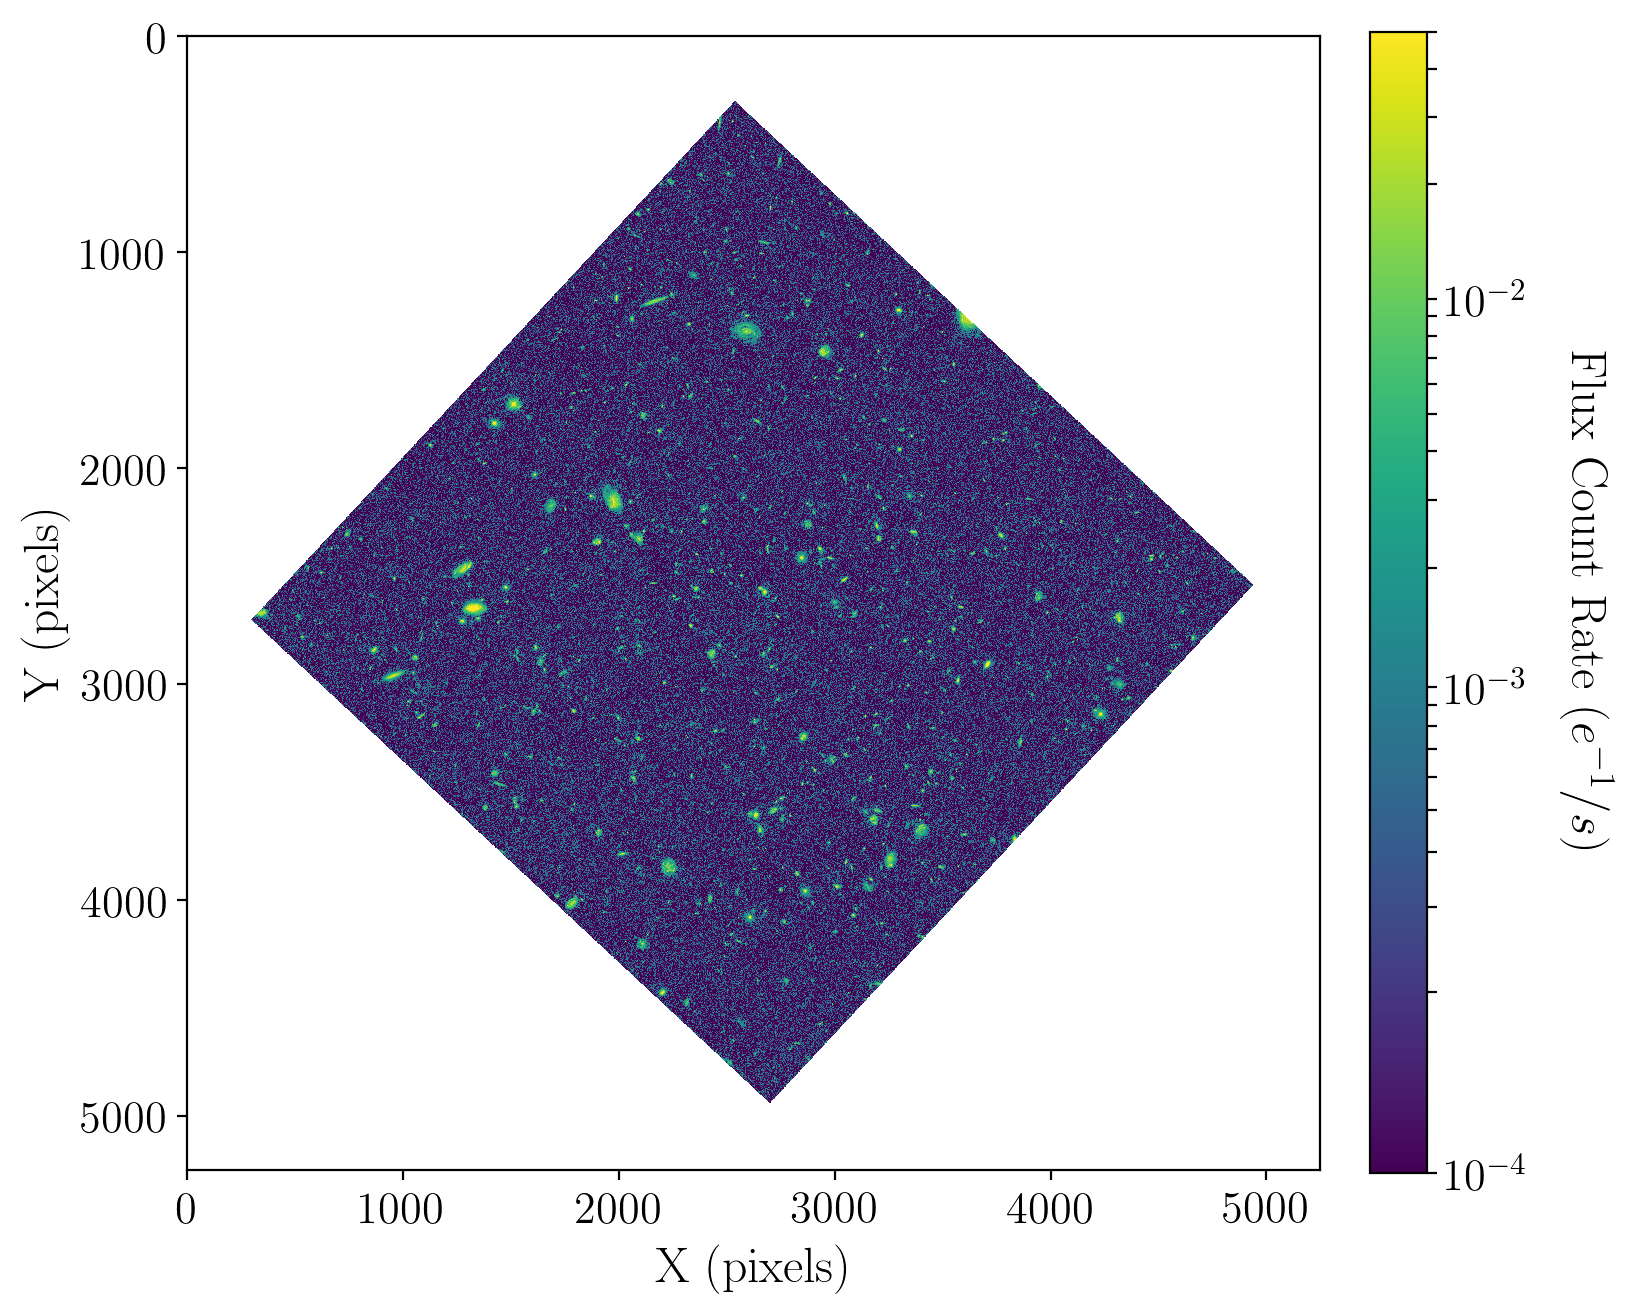

In [15]:
# Set up the figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Plot the data
norm_image = ImageNormalize(vmin=1e-4, vmax=5e-2, stretch=LogStretch())
xdf_2dbkgdsub_clipped = np.clip(xdf_2dbkgdsub, 1e-4, None) # clip to plot with logarithmic stretch
fitsplot = ax1.imshow(np.ma.masked_where(xdf_2dbkgdsub.mask, xdf_2dbkgdsub_clipped), norm=norm_image)

# Define the colorbar and fix the labels
cbar = plt.colorbar(fitsplot, fraction=0.046, pad=0.04, ticks=LogLocator(subs=range(10)))
labels = ['$10^{-4}$'] + [''] * 8 + ['$10^{-3}$'] + [''] * 8 + ['$10^{-2}$']
cbar.ax.set_yticklabels(labels)

# Define labels
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')

plt.show()

---
## Source Detection with `DAOStarFinder`

With the `DAOStarFinder` [class](http://photutils.readthedocs.io/en/stable/api/photutils.DAOStarFinder.html), `photutils` provides users with an easy application of the popular [DAOFIND](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?daofind) algorithm ([Stetson 1987, PASP 99, 191](http://adsabs.harvard.edu/abs/1987PASP...99..191S)), originally developed at the Dominion Astrophysical Observatory. 

This algorithm detects sources by:
* Searching for local maxima
* Selecting only sources with peak amplitude above a defined threshold
* Selecting sources with sizes and shapes that match a 2-D Gaussian kernel

It returns:
* Location of the source centroid
* Parameters reflecting the source's sharpness and roundness

Generally, the threshold that source detection algorithms use is defined as a multiple of the standard deviation. So first, we need to calculate statistics for the data:

In [18]:
mean, median, std = sigma_clipped_stats(xdf_2dbkgdsub.data, sigma=3.0, iters=5, mask=xdf_2dbkgdsub.mask)

Now, let's run the `DAOStarFinder` algorithm on our data and see what it finds. 

In [22]:
from photutils import DAOStarFinder

In [23]:
daofind = DAOStarFinder(fwhm=5.0, threshold=20.*std)
sources_dao = daofind(xdf_2dbkgdsub * ~xdf_2dbkgdsub.mask)    
print(sources_dao)

 id    xcentroid     ycentroid   ...      flux           mag       
---- ------------- ------------- ... ------------- ----------------
   1  2466.8549733   383.4400466 ... 1.02844155818  -0.030449044208
   2   2509.738329 389.514188831 ... 1.56210023552  -0.484272244686
   3 2465.51286522 393.357597326 ... 1.92492172215  -0.711032683532
   4 2525.25521353 393.544062284 ... 11.3241380224   -2.63501288513
   5 2465.22039167 412.428367365 ... 1.11740224029  -0.120523844367
   6 2551.71611445 458.628164677 ... 1.28791443878  -0.274717530234
   7 2613.70435017 463.580036724 ...  1.8605865627  -0.674124700312
   8 2677.99125845 496.090175963 ... 2.10858320935   -0.80997685977
   9  2585.5858743 507.273456713 ... 3.53261587779   -1.37024104149
  10 2325.64476932  553.77336051 ... 1.51360065866  -0.450028270112
 ...           ...           ... ...           ...              ...
1457 2955.91465782 4662.61060561 ... 1.40803661252  -0.371534869275
1458 2814.06917215 4663.41295507 ... 1.453884822

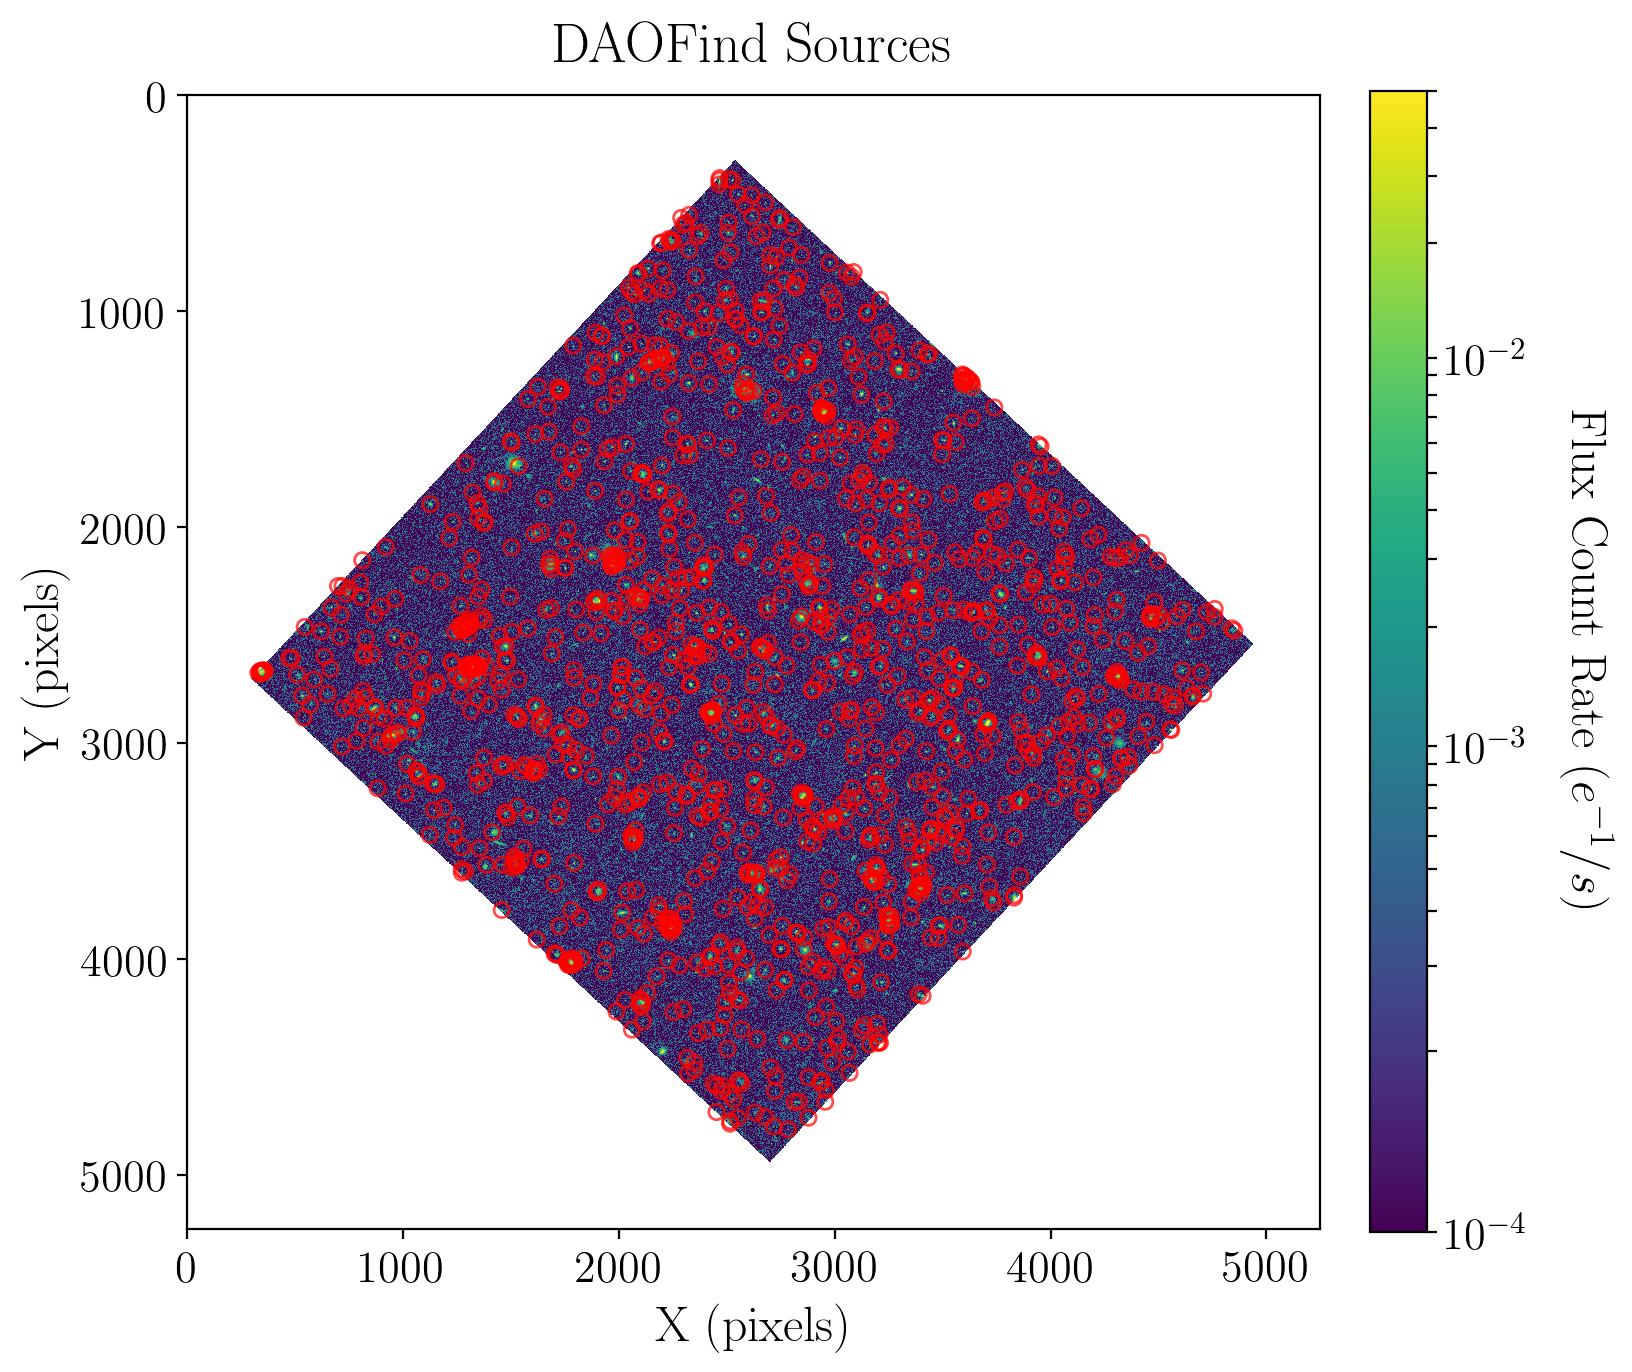

In [24]:
# Set up the figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Plot the data
fitsplot = ax1.imshow(np.ma.masked_where(xdf_2dbkgdsub.mask, xdf_2dbkgdsub_clipped), norm=norm_image)
ax1.scatter(sources_dao['xcentroid'], sources_dao['ycentroid'], s=30, marker='o', 
            lw=1, alpha=0.7, facecolor='None', edgecolor='r')

# Define the colorbar and fix the labels
cbar = plt.colorbar(fitsplot, fraction=0.046, pad=0.04, ticks=LogLocator(subs=range(10)))
labels = ['$10^{-4}$'] + [''] * 8 + ['$10^{-3}$'] + [''] * 8 + ['$10^{-2}$']
cbar.ax.set_yticklabels(labels)

# Define labels
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('DAOFind Sources')

plt.show()

<div class="alert alert-block alert-info">
<h3>**Exercises:**</h3><br>
Re-run the `DAOStarFinder` algorithm with a smaller threshold (like 5&sigma;), and plot the sources that it finds. Do the same, but with a larger threshold (like 100&sigma;). How did changing the threshold affect the results? 

## Source Detection with `IRAFStarFinder`

Similarly to `DAOStarFinder`, `IRAFStarFinder` is a class that implements a pre-existing algorithm that is widely used within the astronomical community. This class uses the [`starfind`](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?starfind) algorithm that was originally part of IRAF.

`IRAFStarFinder` is fundamentally similar to `DAOStarFinder` in that it detects sources by finding local maxima above a certain threshold that match a Gaussian kernel. However, `IRAFStarFinder` differs in the following ways:
* Allows users to specify an elliptical Gaussian kernel
* Uses image moments to calculate the centroids, roundness, and sharpness of objects

Let's run the `IRAFStarFinder` algorithm on our data, with the same FWHM and threshold, and see how its results differ from `DAOStarFinder`:

In [25]:
from photutils import IRAFStarFinder

In [27]:
iraffind = IRAFStarFinder(fwhm=5.0, threshold=20.*std)
sources_iraf = iraffind(xdf_2dbkgdsub * ~xdf_2dbkgdsub.mask)    
print(sources_iraf)

 id   xcentroid     ycentroid   ...      flux            mag      
--- ------------- ------------- ... -------------- ---------------
  1 2509.71903339 389.604714863 ... 0.145116519644    2.0957078648
  2 2613.69411358 463.610285714 ... 0.193817611388   1.78151690746
  3 2635.00022551 470.896270869 ... 0.109746240229   2.39902587307
  4 2585.63515093 507.289853176 ... 0.290729891842   1.34127578319
  5 2297.13103197 600.106635564 ... 0.167608127217   1.93926231629
  6 2806.39192279 610.156476428 ... 0.120267381596   2.29963036045
  7 2506.10412758  636.82379476 ... 0.289753053321   1.34492994723
  8 2326.40767932 717.132722293 ...  0.22564121472   1.61645392739
  9  2516.9536964 727.302446135 ...  0.12704250262   2.24012739908
 10 2702.49277269 740.917164061 ... 0.113582379819   2.36172259015
...           ...           ... ...            ...             ...
201 1701.96127001 3975.70683057 ... 0.373259332494   1.06997331232
202 2677.40754757 4051.00679897 ...  1.14232972884 -0.14447869

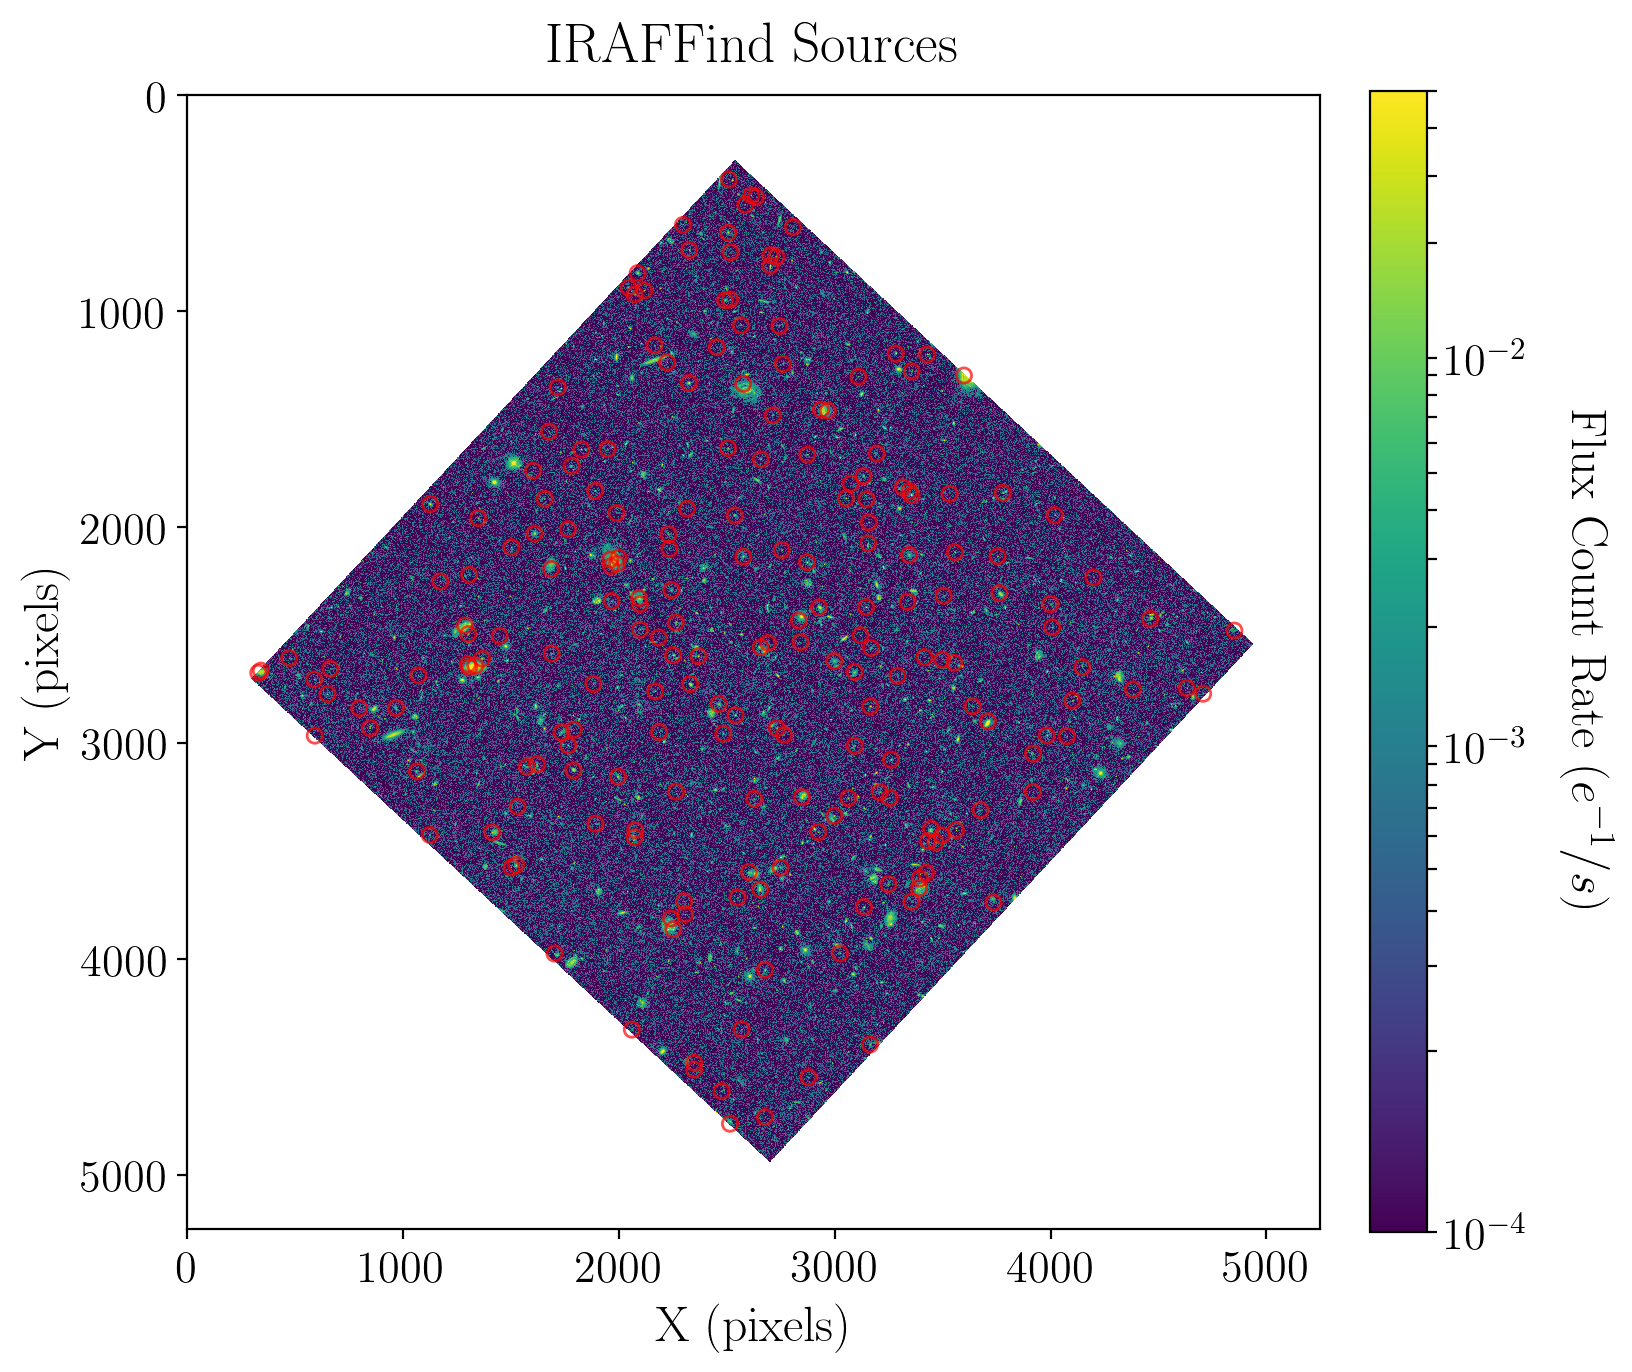

In [28]:
# Set up the figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Plot the data
fitsplot = ax1.imshow(np.ma.masked_where(xdf_2dbkgdsub.mask, xdf_2dbkgdsub_clipped), norm=norm_image)
ax1.scatter(sources_iraf['xcentroid'], sources_iraf['ycentroid'], s=30, marker='o', 
            lw=1, alpha=0.7, facecolor='None', edgecolor='r')

# Define the colorbar and fix the labels
cbar = plt.colorbar(fitsplot, fraction=0.046, pad=0.04, ticks=LogLocator(subs=range(10)))
labels = ['$10^{-4}$'] + [''] * 8 + ['$10^{-3}$'] + [''] * 8 + ['$10^{-2}$']
cbar.ax.set_yticklabels(labels)

# Define labels
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('IRAFFind Sources')

plt.show()

The `IRAFStarFinder` algorithm only found 211 sources in our data - 14% of what `DAOStarFinder` found. Why?

## Source Detection with `find_peaks`

For more general source detection cases that do not require rigorous comparison with models, `photutils` offers the `find_peaks` function. This function simply finds sources by identifying local maxima above a given threshold and separated by a given distance. Unlike the previous detection algorithms, `find_peaks` does not necessarily calculate objects' centroids. Unless the `subpixel` argument is set to `True`, `find_peaks` will return just the integer value of the peak pixel for each source.

This algorithm is particularly useful for identifying non-stellar sources or heavily distorted sources in image data.

Let's see how it does:

In [32]:
from photutils import find_peaks

In [35]:
sources_findpeaks = find_peaks(xdf_2dbkgdsub.data, mask=xdf_2dbkgdsub.mask, 
                               threshold=20.*std, box_size=30, subpixel=True)    
print(sources_findpeaks)

x_peak y_peak    peak_value     x_centroid    y_centroid   fit_peak_value 
------ ------ --------------- ------------- ------------- ----------------
  2525    393  0.135451431669 2525.26336344 393.522873509   0.148650154217
  2466    400 0.0293336217897 2465.79286017 398.043364628  0.0176606822995
  2552    459 0.0182768105637 2552.27027749 458.677562683  0.0128598945238
  2614    463 0.0181947905506 2613.69613343 463.585076076  0.0188133711757
  2635    471   0.02110125573 2634.95133293 470.852386839  0.0202602906652
  2635    493 0.0802389496746 2634.69820691  492.74148748  0.0884658508479
  2678    496 0.0263793695322 2678.00665363 496.104221038  0.0231172450607
  2586    507 0.0371396664944 2585.55584526 507.289268428  0.0407944364417
  2326    554 0.0180919227549 2325.61909864 553.721724536  0.0163059002803
  2616    560 0.0214566899806 2615.88885262 559.974613217  0.0184869253028
   ...    ...             ...           ...           ...              ...
  2531   4651 0.017485019

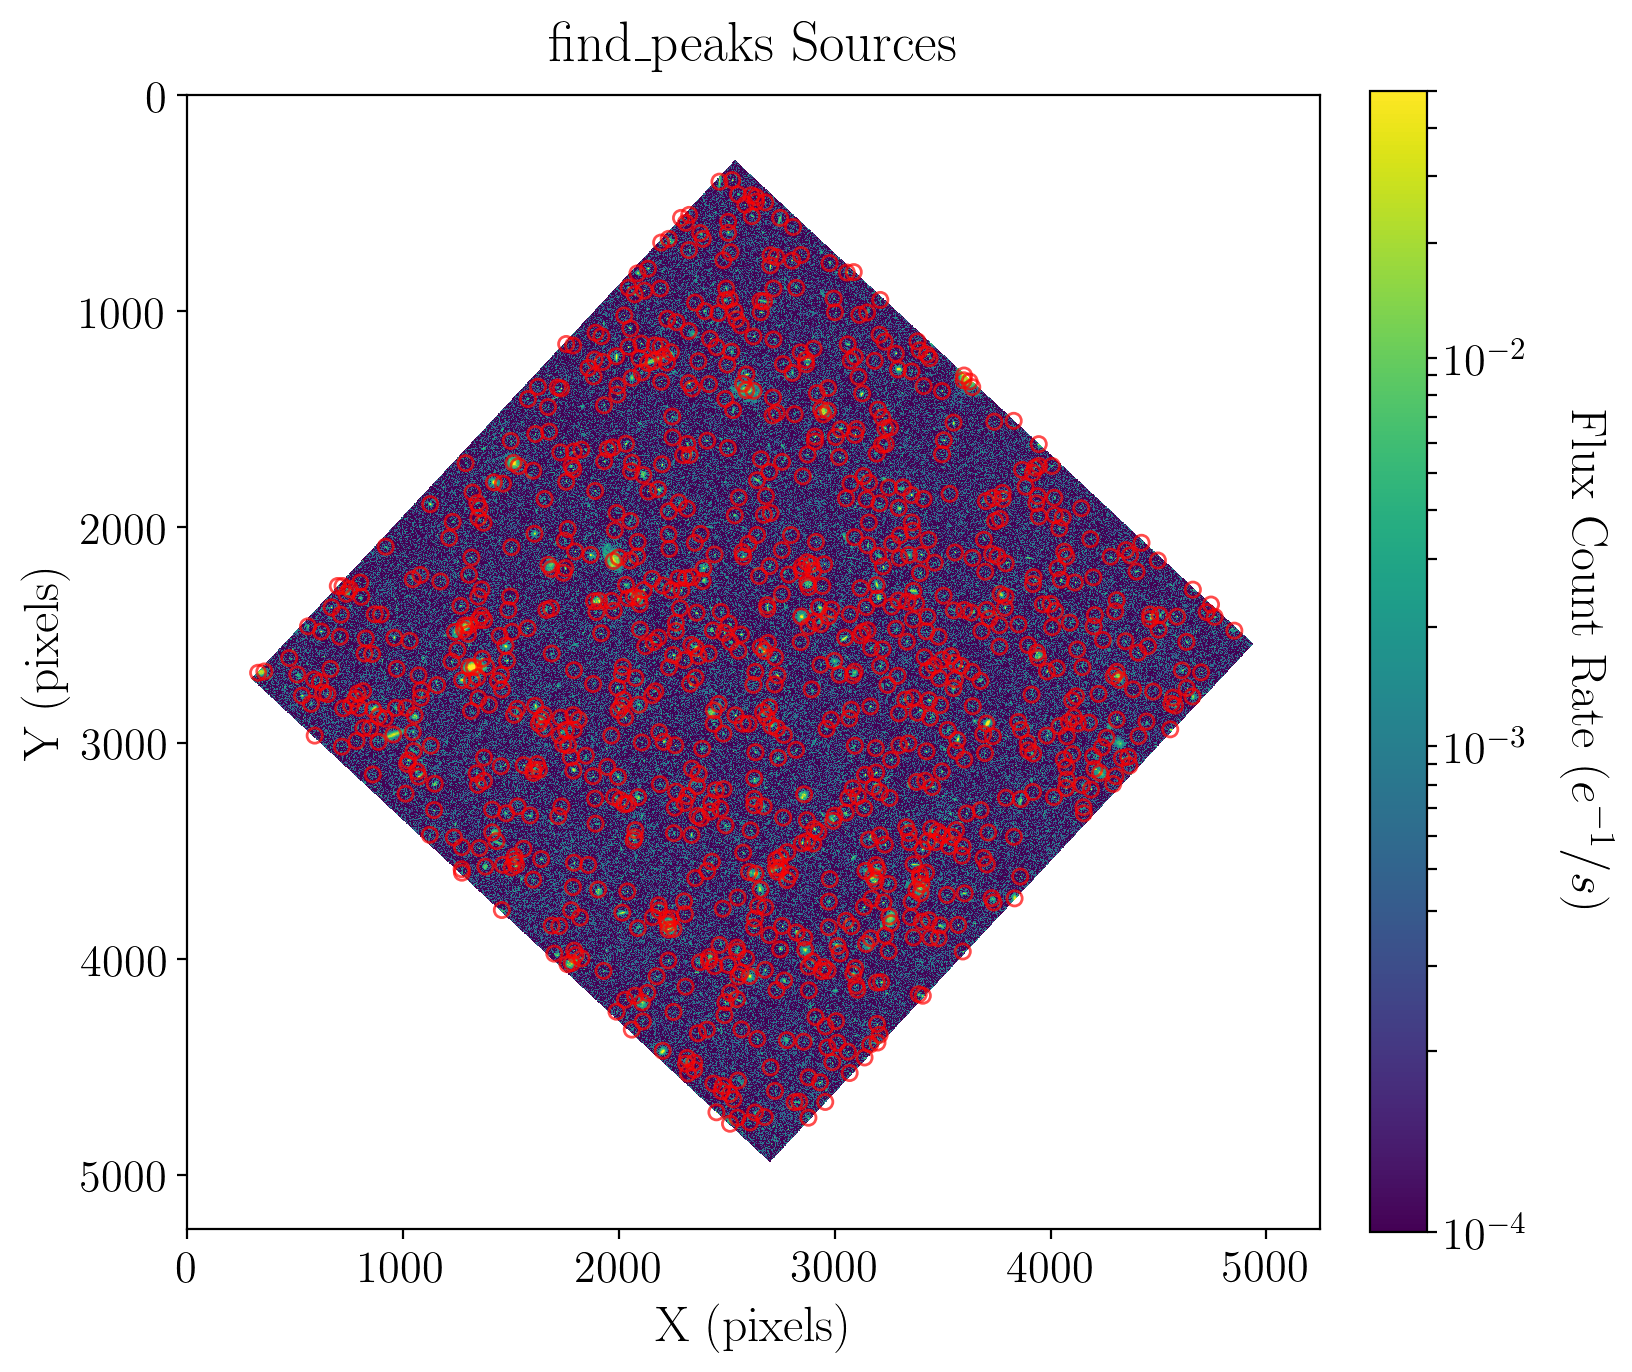

In [36]:
# Set up the figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Plot the data
fitsplot = ax1.imshow(np.ma.masked_where(xdf_2dbkgdsub.mask, xdf_2dbkgdsub_clipped), norm=norm_image)
ax1.scatter(sources_findpeaks['x_peak'], sources_findpeaks['y_peak'], s=30, marker='o', 
            lw=1, alpha=0.7, facecolor='None', edgecolor='r')

# Define the colorbar
cbar = plt.colorbar(fitsplot, fraction=0.046, pad=0.04, ticks=LogLocator(subs=range(10)))
labels = ['$10^{-4}$'] + [''] * 8 + ['$10^{-3}$'] + [''] * 8 + ['$10^{-2}$']
cbar.ax.set_yticklabels(labels)

# Define labels
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('find\_peaks Sources')

plt.show()

## Image Segmentation and Deblending

In [29]:
from photutils import detect_sources
from photutils.utils import random_cmap

In [40]:
npixels = 50
segm = detect_sources(xdf_2dbkgdsub.data, 20.*std, npixels)
print('Found {0} sources'.format(segm.max))

Found 77 sources


In [131]:
print(dir(rand_cmap))

['N', '__call__', '__class__', '__copy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_i_bad', '_i_over', '_i_under', '_init', '_isinit', '_lut', '_resample', '_rgba_bad', '_rgba_over', '_rgba_under', '_set_extremes', 'colorbar_extend', 'colors', 'is_gray', 'monochrome', 'name', 'reversed', 'set_bad', 'set_over', 'set_under']


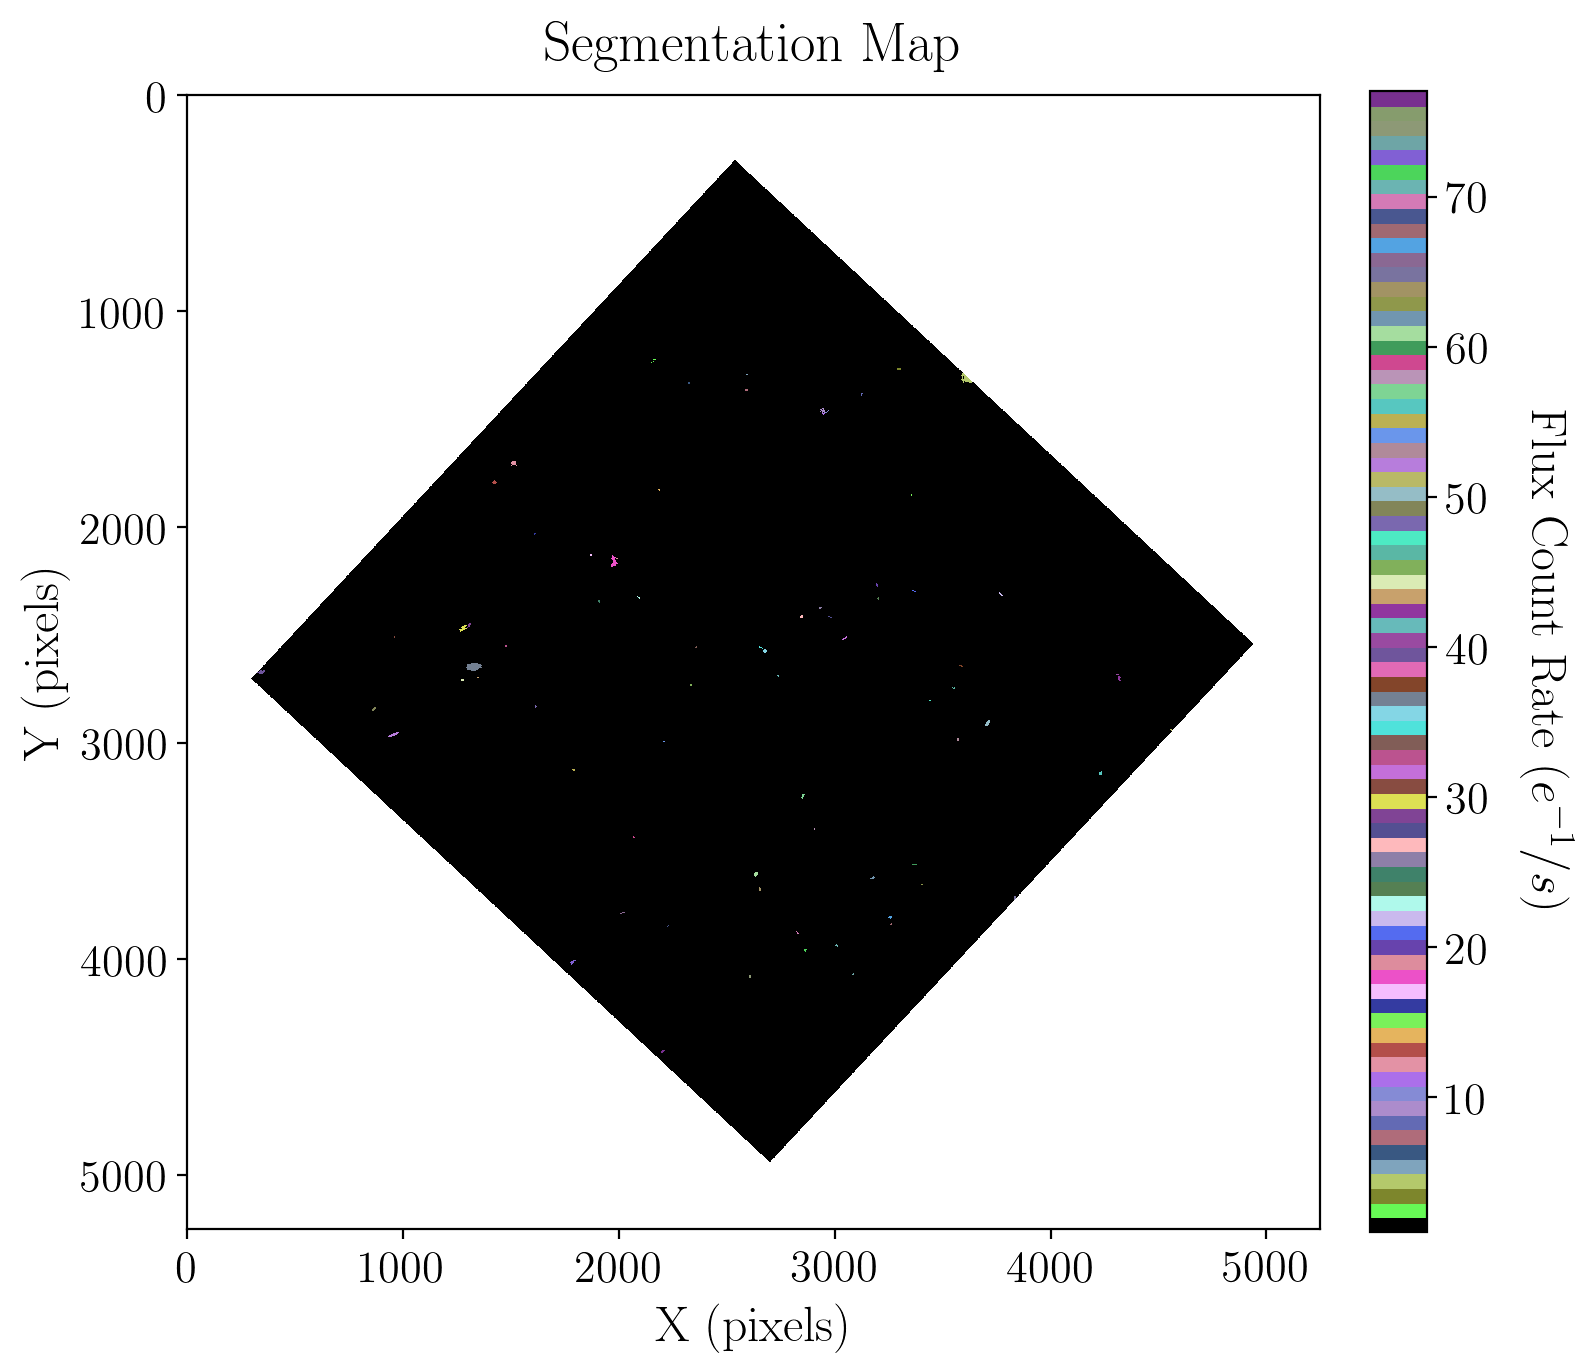

In [50]:
# Set up the figure with subplots
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Plot the data
rand_cmap = random_cmap(random_state=12345)
rand_cmap.set_under('white')

# norm_image = ImageNormalize(nddata.data, interval=ZScaleInterval())
# fitsplot = ax1.imshow(np.ma.masked_where(nddata.mask, nddata.data), norm=norm_image)
# ax1.scatter(sources_findpeaks['x_peak'], sources_findpeaks['y_peak'], c='red', s=2)
segplot = ax1.imshow(np.ma.masked_where(xdf_2dbkgdsub.mask, segm), vmin=1, cmap=segm.cmap(random_state=12345))

# Define the colorbar
cbar = plt.colorbar(segplot, fraction=0.046, pad=0.04)

# Define labels
cbar.set_label(r'Flux Count Rate ($e^{-1}/s$)', rotation=270, labelpad=30)
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.set_title('Segmentation Map')

plt.show()

In [75]:
from photutils import deblend_sources
segm2 = deblend_sources(nddata.data * ~nddata.mask, segm, npixels, filter_kernel=kernel,
                        contrast=0.001, nlevels=32)
plt.imshow(segm2, cmap=rand_cmap)
print('Found {0} sources'.format(segm2.max))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.imshow(scale_image(data, scale='sqrt', percent=99.5))
ax2.imshow(segm2, cmap=rand_cmap)

NameError: name 'kernel' is not defined

---
## Exercises

##### To continue with this `photutils` tutorial, go on to the [aperture photometry](03_photutils_aperture_photometry.ipynb) or [PSF photometry notebook](04_photutils_psf_photometry.ipynb).

---
<i>May 2018

Author: Lauren Chambers (lchambers@stsci.edu)

For more examples and details, please visit the [photutils](http://photutils.readthedocs.io/en/stable/index.html) documentation.</i>